In [115]:
# import all required libraries
import sys
import subprocess
import os

# list of packages to install
# make sure to place kaggle.json in C:/users/<user>/.kaggle
packages = ["kaggle", "numpy", "pandas", "tensorflow", "matplotlib", "pillow", "scikit-learn"]

# install packages if needed
for package in packages:
    try:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--quiet"])
        print(f"{package} installed successfully!")
    except Exception as e:
        print(f"Error installing {package}: {e}")

# import libraries after installation
try:
    import numpy as np
    import pandas as pd
    import tensorflow as tf
    import matplotlib
    import matplotlib.pyplot as plt
    from PIL import Image
    import sklearn
    import kaggle
    
    # check versions of installed packages before continuing to ensure it will run properly
    print("\nInstallation Summary:")
    print(f"NumPy version: {np.__version__}")
    print(f"Pandas version: {pd.__version__}")
    print(f"TensorFlow version: {tf.__version__}")
    print(f"Matplotlib version: {matplotlib.__version__}")
    print(f"PIL version: {Image.__version__}")
    print(f"scikit-learn version: {sklearn.__version__}")
    
    # verify Kaggle API setup
    kaggle_path = os.path.join(os.path.expanduser('~'), '.kaggle', 'kaggle.json')
    if os.path.exists(kaggle_path):
        print("Kaggle API credentials found.")
    else:
        print("\nWARNING: Kaggle API credentials not found!")
        print("Please place your kaggle.json file in:", kaggle_path)
        print("You can download this file from https://www.kaggle.com/account")
    
    print("\nAll required packages are installed and ready to use!")
    
except ImportError as e:
    print(f"\nError importing libraries: {e}")
    print("Please try restarting your notebook/kernel and run this cell again.")

Installing kaggle...
kaggle installed successfully!
Installing numpy...
numpy installed successfully!
Installing pandas...
pandas installed successfully!
Installing tensorflow...
tensorflow installed successfully!
Installing matplotlib...
matplotlib installed successfully!
Installing pillow...
pillow installed successfully!
Installing scikit-learn...
scikit-learn installed successfully!

Installation Summary:
NumPy version: 2.1.3
Pandas version: 2.2.3
TensorFlow version: 2.20.0
Matplotlib version: 3.10.0
PIL version: 11.1.0
scikit-learn version: 1.6.1
Kaggle API credentials found.

All required packages are installed and ready to use!


Loading data...
✅ Loaded train.csv: 79950 rows
✅ Loaded test.csv: 5540 rows
Train columns: ['#', 'file_name', 'label']
Test columns: ['id']

Functions loaded successfully.

Available Commands:
  preview_training_images(16)    # show training images
  preview_test_images(16)        # show test images
  resize_training_images()       # resize training images to 512x512
  resize_test_images()           # resize test images to 512x512
  show_data_info()               # show dataset info

TRAINING IMAGES PREVIEW
Using filename column: 'file_name'
Using label column: 'label'
Label distribution: {'AI': np.int64(39975), 'Human': np.int64(39975)}


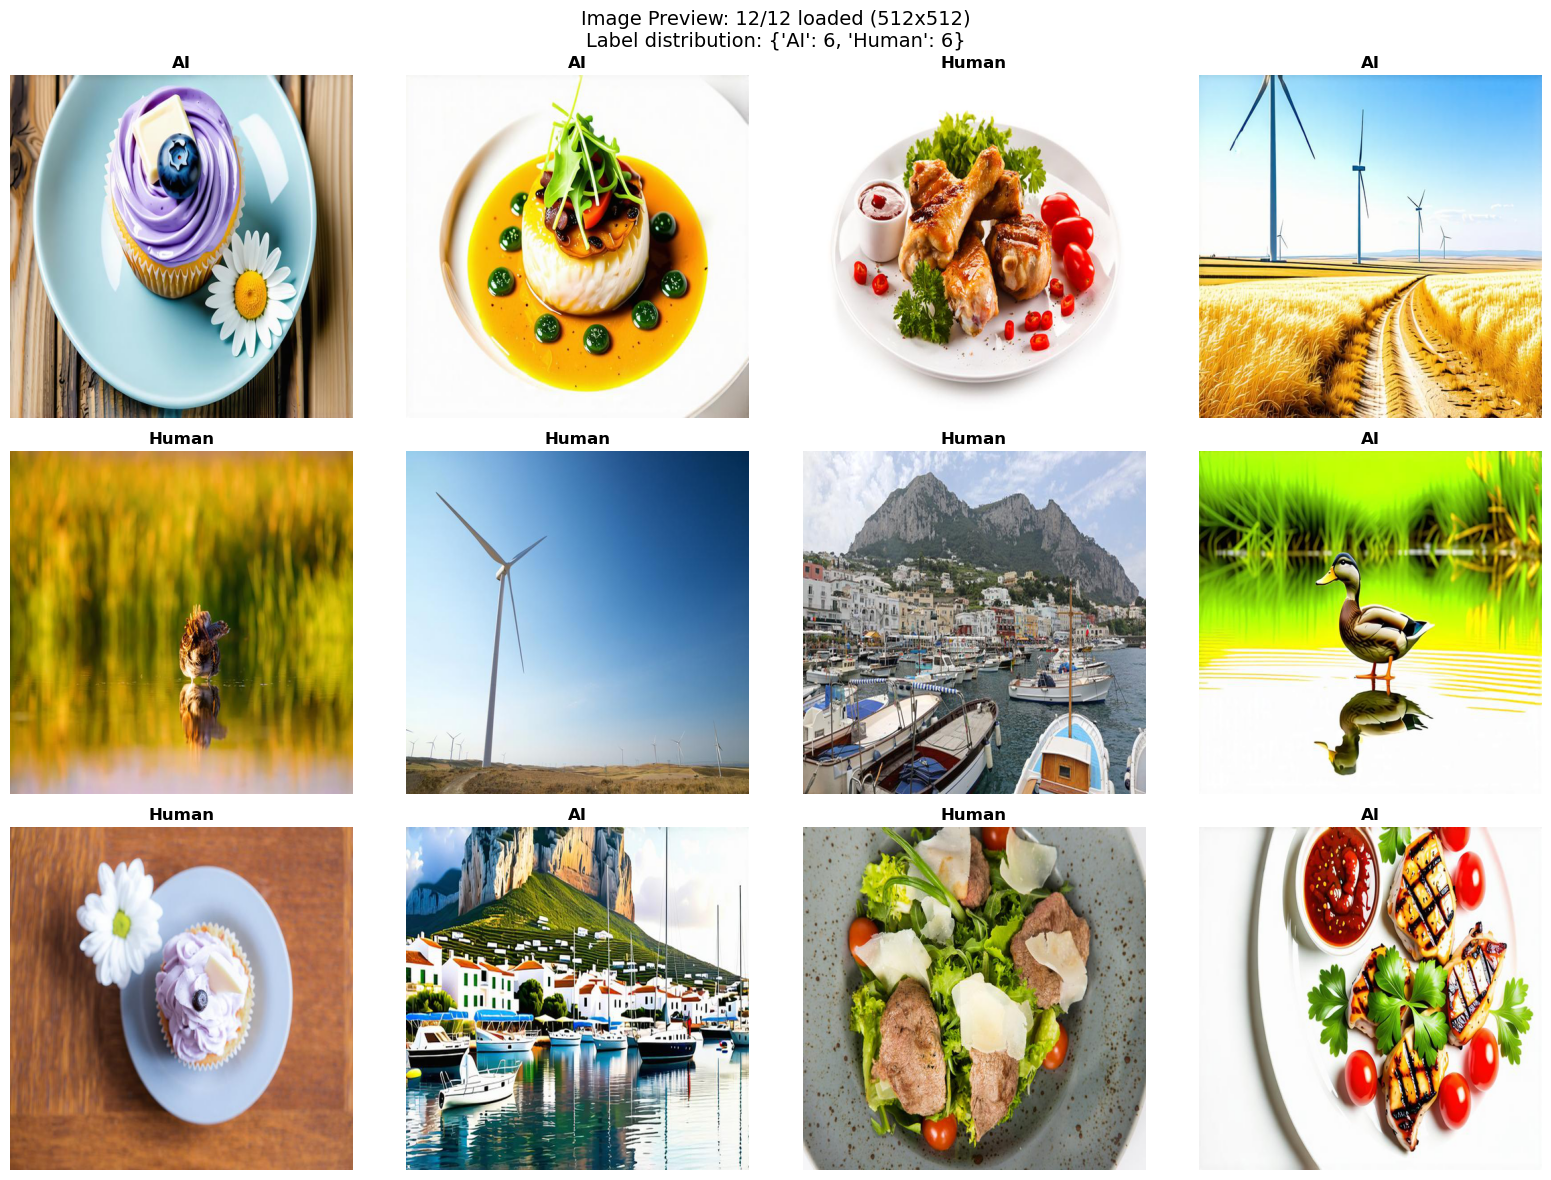

Successfully loaded: 12/12 images
DATA INFORMATION
Training data: 79950 rows
Columns: ['#', 'file_name', 'label']
Label distribution: {'AI': np.int64(39975), 'Human': np.int64(39975)}

Test data: 5540 rows
Columns: ['id']


In [116]:
from collections import Counter

# define local file paths
TRAIN_CSV = r"C:\Users\adras\OneDrive\Desktop\Capstone\train.csv"
TEST_CSV = r"C:\Users\adras\OneDrive\Desktop\Capstone\test.csv"
TRAIN_IMAGE_DIR = r"C:\Users\adras\train_data"
TEST_IMAGE_DIR = r"C:\Users\adras\test_data"

def load_dataframes():
    """Load the CSV files"""
    try:
        train_df = pd.read_csv(TRAIN_CSV)
        test_df = pd.read_csv(TEST_CSV)
        
        print(f"Loaded train.csv: {len(train_df)} rows")
        print(f"Loaded test.csv: {len(test_df)} rows")
        print(f"Train columns: {list(train_df.columns)}")
        print(f"Test columns: {list(test_df.columns)}")
        
        return train_df, test_df
    except Exception as e:
        print(f"Error loading CSV files: {e}")
        return None, None

def load_image(filename, image_dir, target_size=(512, 512)):
    """Load and resize image with better error handling"""
    
    # clean file names to handle different formats
    clean_filename = str(filename).replace('train_data/', '').replace('test_data/', '').replace('\\', '/')
    
    possible_paths = [
        os.path.join(image_dir, clean_filename),
        os.path.join(image_dir, os.path.basename(clean_filename)),
        os.path.join(image_dir, filename) if isinstance(filename, str) else None
    ]
    
    for img_path in possible_paths:
        if img_path and os.path.exists(img_path):
            try:
                img = Image.open(img_path).convert('RGB')
                return np.array(img.resize(target_size, Image.Resampling.LANCZOS))
            except Exception as e:
                continue
    
    return None

def find_filename_column(df):
    """Find the filename column with more options"""
    possible_names = ['filename', 'image', 'file', 'image_name', 'img', 'name', 'file_name', 'path']

    # try exact matches
    for col in df.columns:
        if col.lower() in possible_names:
            return col

    # try partial matches
    for col in df.columns:
        col_lower = col.lower()
        if any(name in col_lower for name in possible_names):
            return col
    
    return df.columns[0]

def find_label_column(df):
    """Find the label column (0/1 values) with better detection"""
    possible_names = ['label', 'target', 'class', 'y', 'is_ai', 'ai', 'real']
    
    for col in df.columns:
        if col.lower() in possible_names:
            unique_vals = set(df[col].dropna().astype(str).unique())
            if unique_vals.issubset({'0', '1', '0.0', '1.0', 'True', 'False', 'true', 'false'}):
                return col
    
    # look for any binary columns to label for grid (0 is 'Human, 1 is 'AI)
    for col in df.columns:
        try:
            non_null_values = df[col].dropna()
            if len(non_null_values) > 0:
                unique_vals = set(non_null_values.astype(str).unique())
                if unique_vals.issubset({'0', '1', '0.0', '1.0', 'True', 'False', 'true', 'false'}):
                    return col
        except:
            continue
    
    return None

def get_label_text(label_value):
    """Convert 0/1 to Human/AI with better handling"""
    if pd.isna(label_value):
        return "Unknown"
    
    try:
        val_str = str(label_value).lower()
        if val_str in ['1', '1.0', 'true', 'ai']:
            return "AI"
        elif val_str in ['0', '0.0', 'false', 'human', 'real']:
            return "Human"
        else:
            return str(label_value)
    except:
        return str(label_value)

def preview_images(df, image_dir, target_size=(512, 512), num_samples=16):
    """Preview random images in a grid with improved display"""
    
    if df is None or len(df) == 0:
        print("No data to preview")
        return
    
    filename_col = find_filename_column(df)
    label_col = find_label_column(df)
    
    print(f"Using filename column: '{filename_col}'")
    if label_col:
        print(f"Using label column: '{label_col}'")
        # show label distribution
        label_dist = df[label_col].apply(get_label_text).value_counts()
        print(f"Label distribution: {dict(label_dist)}")
    
    # sample images of balanced classes with labels
    if label_col and len(df[label_col].unique()) > 1:
        samples_per_class = num_samples // len(df[label_col].unique())
        sample_df = df.groupby(label_col).apply(
            lambda x: x.sample(min(len(x), samples_per_class), random_state=42)
        ).reset_index(drop=True)
        sample_df = sample_df.sample(min(num_samples, len(sample_df)), random_state=42)
    else:
        sample_df = df.sample(min(num_samples, len(df)), random_state=42)
    
    # create 4x4 grid
    cols = 4
    rows = (num_samples + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(16, 4*rows))
    
    if rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()
    
    loaded_count = 0
    labels_shown = []
    
    for i, (_, row) in enumerate(sample_df.iterrows()):
        if i >= num_samples:
            break
            
        filename = str(row[filename_col])
        img = load_image(filename, image_dir, target_size)
        
        if img is not None:
            axes[i].imshow(img)
            loaded_count += 1
            
            if label_col:
                label_text = get_label_text(row[label_col])
                axes[i].set_title(label_text, fontsize=12, color='black', weight='bold')
                labels_shown.append(label_text)
        else:
            axes[i].text(0.5, 0.5, "Image\nNot Found", ha='center', va='center', 
                        color='red', fontsize=12, weight='bold')
            
            if label_col:
                label_text = get_label_text(row[label_col])
                axes[i].set_title(f"{label_text} (Missing)", fontsize=10, color='red')
        
        axes[i].axis('off')
    
    # hide unused subplots
    for i in range(num_samples, len(axes)):
        axes[i].axis('off')
    
    # create title
    title = f'Image Preview: {loaded_count}/{num_samples} loaded ({target_size[0]}x{target_size[1]})'
    if label_col and labels_shown:
        label_counts = dict(Counter(labels_shown))
        title += f'\nLabel distribution: {label_counts}'
    
    plt.suptitle(title, fontsize=14, weight='normal')
    plt.tight_layout()
    plt.show()
    
    print(f"Successfully loaded: {loaded_count}/{num_samples} images")

def resize_images(df, input_dir, output_dir, target_size=(512, 512)):
    """Resize all images and save to output directory"""
    
    if df is None or len(df) == 0:
        print("No data to process")
        return
    
    filename_col = find_filename_column(df)
    os.makedirs(output_dir, exist_ok=True)
    
    print(f"Resizing {len(df)} images to {target_size[0]}x{target_size[1]}...")
    
    success_count = 0
    
    for i, (_, row) in enumerate(df.iterrows()):
        filename = str(row[filename_col])
        img = load_image(filename, input_dir, target_size)
        
        if img is not None:
            clean_filename = os.path.basename(filename)
            output_path = os.path.join(output_dir, clean_filename)
            
            try:
                Image.fromarray(img.astype('uint8')).save(output_path)
                success_count += 1
            except Exception as e:
                print(f"Error saving {clean_filename}: {e}")
        
        # Progress indicator
        if (i + 1) % 100 == 0 or i == len(df) - 1:
            print(f"  Progress: {i + 1}/{len(df)} ({(i+1)/len(df)*100:.1f}%)")
    
    print(f"Successfully resized: {success_count}/{len(df)} images")

# load data and test functions
print("Loading data...")
train_df, test_df = load_dataframes()

def preview_training_images(samples=16):
    """Preview training images"""
    if train_df is not None:
        print("\nTRAINING IMAGES PREVIEW")
        preview_images(train_df, TRAIN_IMAGE_DIR, num_samples=samples)
    else:
        print("Training data not loaded")

def preview_test_images(samples=16):
    """Preview test images"""
    if test_df is not None:
        print("\nTEST IMAGES PREVIEW")
        preview_images(test_df, TEST_IMAGE_DIR, num_samples=samples)
    else:
        print("Test data not loaded")

def resize_training_images(output_dir="train_images_512x512", size=(512, 512)):
    """Resize all training images"""
    if train_df is not None:
        resize_images(train_df, TRAIN_IMAGE_DIR, output_dir, size)
    else:
        print("Training data not loaded")

def resize_test_images(output_dir="test_images_512x512", size=(512, 512)):
    """Resize all test images"""
    if test_df is not None:
        resize_images(test_df, TEST_IMAGE_DIR, output_dir, size)
    else:
        print("Test data not loaded")

def show_data_info():
    """Show dataset information"""
    print("DATA INFORMATION")
    print("=" * 50)
    
    if train_df is not None:
        print(f"Training data: {len(train_df)} rows")
        print(f"Columns: {list(train_df.columns)}")
        
        filename_col = find_filename_column(train_df)
        label_col = find_label_column(train_df)
        
        if label_col:
            label_dist = train_df[label_col].apply(get_label_text).value_counts()
            print(f"Label distribution: {dict(label_dist)}")
    
    if test_df is not None:
        print(f"\nTest data: {len(test_df)} rows")
        print(f"Columns: {list(test_df.columns)}")

# show available commands
if train_df is not None and test_df is not None:
    print("\nFunctions loaded successfully.")
    print("\nAvailable Commands:")
    print("  preview_training_images(16)    # show training images")
    print("  preview_test_images(16)        # show test images") 
    print("  resize_training_images()       # resize training images to 512x512")
    print("  resize_test_images()           # resize test images to 512x512")
    print("  show_data_info()               # show dataset info")
    
    # auto-preview
    preview_training_images(12)
    show_data_info()
else:
    print("Failed to load data. Check file paths.")

In [117]:
import warnings
warnings.filterwarnings('ignore')

# import deep learning libraries
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# traditional ML imports
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# set style for better plots
plt.style.use('default')
sns.set_palette("husl")

print("AI Image Detection - Model Comparison Tool")
print("="*60)

class Config:
    # File paths
    TRAIN_CSV = r"C:\Users\adras\OneDrive\Desktop\Capstone\train.csv"
    TEST_CSV = r"C:\Users\adras\OneDrive\Desktop\Capstone\test.csv"
    TRAIN_IMAGE_DIR = r"C:\Users\adras\train_data"
    TEST_IMAGE_DIR = r"C:\Users\adras\test_data"
    
    # model parameters
    IMG_SIZE = (224, 224)
    BATCH_SIZE = 16
    EPOCHS = 10
    MAX_SAMPLES = 2000  # reduced for performance
    
    # display settings
    FIGURE_SIZE = (12, 8)
    DPI = 100

config = Config()

def check_files_exist():
    """Check if all required files exist"""
    files_to_check = [
        (config.TRAIN_CSV, "Train CSV"),
        (config.TEST_CSV, "Test CSV"),
        (config.TRAIN_IMAGE_DIR, "Train Images Directory"),
        (config.TEST_IMAGE_DIR, "Test Images Directory")
    ]
    
    all_exist = True
    for file_path, description in files_to_check:
        if os.path.exists(file_path):
            print(f"{description}: Found")
        else:
            print(f"{description}: NOT FOUND - {file_path}")
            all_exist = False
    
    return all_exist

def load_data():
    """Load CSV files and return dataframes"""
    try:
        train_df = pd.read_csv(config.TRAIN_CSV)
        test_df = pd.read_csv(config.TEST_CSV)
        
        print(f"Train dataset: {len(train_df)} rows, {len(train_df.columns)} columns")
        print(f"Test dataset: {len(test_df)} rows, {len(test_df.columns)} columns")
        
        print("\nTrain columns:", list(train_df.columns))
        print("Test columns:", list(test_df.columns))
        
        return train_df, test_df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None

def find_columns(df):
    """Auto-detect filename and label columns with better logic"""
    filename_col = None
    label_col = None
    
    print(f"Available columns: {list(df.columns)}")
    print(f"Sample data:\n{df.head(2)}")
    
    # find filename column
    filename_candidates = ['filename', 'image', 'file', 'image_name', 'img', 'name', 'path']
    for col in df.columns:
        col_lower = col.lower()
        if any(candidate in col_lower for candidate in filename_candidates):
            filename_col = col
            break
    
    if not filename_col:
        filename_col = df.columns[0]
        print(f"Using first column as filename: {filename_col}")
    
    # find label column
    label_candidates = ['label', 'target', 'class', 'y', 'is_ai', 'ai', 'real']
    for col in df.columns:
        col_lower = col.lower()
        if any(candidate in col_lower for candidate in label_candidates):
            unique_vals = set(df[col].dropna().unique())
            # Check if it's binary (0/1 or similar)
            if unique_vals.issubset({0, 1, 0.0, 1.0, '0', '1', True, False}):
                label_col = col
                break
    
    if not label_col:
        for col in df.columns:
            if col != filename_col:
                try:
                    unique_vals = set(df[col].dropna().astype(str).unique())
                    if unique_vals.issubset({'0', '1', 'True', 'False', '0.0', '1.0'}):
                        label_col = col
                        break
                except:
                    continue
    
    print(f"Filename column: '{filename_col}'")
    print(f"Label column: '{label_col}'")
    
    return filename_col, label_col

def load_and_preprocess_image(filename, image_dir, target_size=None):
    """Load and preprocess a single image with better error handling"""
    if target_size is None:
        target_size = config.IMG_SIZE
    
    clean_filename = str(filename).replace('\\', '/').replace('train_data/', '').replace('test_data/', '')
    
    possible_paths = [
        os.path.join(image_dir, clean_filename),
        os.path.join(image_dir, os.path.basename(clean_filename)),
        os.path.join(image_dir, filename) if isinstance(filename, str) else None
    ]
    
    for img_path in possible_paths:
        if img_path and os.path.exists(img_path):
            try:
                img = Image.open(img_path).convert('RGB')
                img = img.resize(target_size, Image.Resampling.LANCZOS)
                img_array = np.array(img) / 255.0  # Normalize to [0,1]
                return img_array
            except Exception as e:
                continue
    
    return None

def preview_dataset(df, image_dir, num_samples=16):
    """Preview sample images with labels - Jupyter optimized"""
    filename_col, label_col = find_columns(df)
    
    if label_col is None:
        print("No valid label column found!")
        return
    
    # get class distribution
    class_counts = df[label_col].value_counts()
    print(f"\nDataset distribution: {dict(class_counts)}")
    
    # sample data
    if len(class_counts) > 1:
        samples_per_class = num_samples // len(class_counts)
        sample_df = df.groupby(label_col).apply(
            lambda x: x.sample(min(len(x), samples_per_class), random_state=42)
        ).reset_index(drop=True)
        sample_df = sample_df.sample(min(num_samples, len(sample_df)), random_state=42)
    else:
        sample_df = df.sample(min(num_samples, len(df)), random_state=42)
    
    # create subplot
    cols = 4
    rows = (num_samples + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(15, 4*rows), dpi=config.DPI)
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
    
    loaded_count = 0
    
    for i, (_, row) in enumerate(sample_df.iterrows()):
        if i >= num_samples:
            break
            
        filename = str(row[filename_col])
        img = load_and_preprocess_image(filename, image_dir)
        
        if img is not None:
            axes[i].imshow(img)
            loaded_count += 1
            
            label_val = row[label_col]
            # handle different label formats
            if str(label_val).lower() in ['1', '1.0', 'true', 'ai']:
                label_text = "AI Generated"
                color = 'red'
            else:
                label_text = "Human/Real"
                color = 'blue'
            
            axes[i].set_title(f"{label_text}\n({filename[:20]}...)", fontsize=10, color=color, weight='bold')
        else:
            axes[i].text(0.5, 0.5, f"Image Not Found\n{filename[:20]}...", 
                        ha='center', va='center', color='red', fontsize=8)
        
        axes[i].axis('off')
    
    # hide unused subplots
    for i in range(num_samples, len(axes)):
        axes[i].axis('off')
    
    plt.suptitle(f'Sample Images Preview ({loaded_count}/{num_samples} loaded)', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    return loaded_count > 0

def load_dataset(df, image_dir, max_samples=None):
    """Load and prepare dataset for training with progress tracking"""
    if max_samples is None:
        max_samples = config.MAX_SAMPLES
    
    filename_col, label_col = find_columns(df)
    
    if label_col is None:
        print("No valid label column found!")
        return None, None
    
    print(f"\nLoading dataset (max {max_samples} samples)...")
    
    # sample data while maintaining class balance
    if len(df) > max_samples:
        class_counts = df[label_col].value_counts()
        samples_per_class = max_samples // len(class_counts)
        
        df_sample = df.groupby(label_col).apply(
            lambda x: x.sample(min(len(x), samples_per_class), random_state=42)
        ).reset_index(drop=True).sample(frac=1, random_state=42)
    else:
        df_sample = df.copy()
    
    images = []
    labels = []
    failed_files = []
    
    print(f"Processing {len(df_sample)} images...")
    
    for i, (_, row) in enumerate(df_sample.iterrows()):
        filename = str(row[filename_col])
        img = load_and_preprocess_image(filename, image_dir)
        
        if img is not None:
            images.append(img)
            # ensure labels are binary (0/1)
            label_val = row[label_col]
            if str(label_val).lower() in ['1', '1.0', 'true', 'ai']:
                labels.append(1)
            else:
                labels.append(0)
        else:
            failed_files.append(filename)
        
        # progress indicator
        if (i + 1) % 100 == 0 or i == len(df_sample) - 1:
            print(f"  Progress: {i + 1}/{len(df_sample)} ({(i+1)/len(df_sample)*100:.1f}%)")
    
    if not images:
        print("No images could be loaded!")
        return None, None
    
    X = np.array(images)
    y = np.array(labels)
    
    print(f"\nDataset loaded successfully!")
    print(f"  Images shape: {X.shape}")
    print(f"  Labels distribution: {Counter(y)}")
    print(f"  Failed to load: {len(failed_files)} images")
    
    if failed_files and len(failed_files) <= 5:
        print(f"  First few failed files: {failed_files[:5]}")
    
    return X, y

def create_optimized_models():
    """Create optimized models with callbacks"""
    models = {}
    
    # early stopping and learning rate reduction
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7)
    callbacks = [early_stopping, reduce_lr]
    
    # 1. ResNet50 transfer learning
    print("Creating ResNet50 model...")
    base_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(*config.IMG_SIZE, 3))
    base_resnet.trainable = False  # Freeze base layers
    
    resnet_model = Sequential([
        base_resnet,
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    
    resnet_model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    models['ResNet50'] = {'model': resnet_model, 'callbacks': callbacks}
    
    # 2. Custom CNN
    print("Creating Custom CNN model...")
    custom_cnn = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(*config.IMG_SIZE, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    custom_cnn.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    models['Custom CNN'] = {'model': custom_cnn, 'callbacks': callbacks}
    
    return models

def train_models(X, y):
    """Train all models with proper validation and progress tracking"""
    # split data
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"\nData split:")
    print(f"  Training: {len(X_train)} images")
    print(f"  Validation: {len(X_val)} images")
    print(f"  Training distribution: {Counter(y_train)}")
    print(f"  Validation distribution: {Counter(y_val)}")
    
    # create models
    models = create_optimized_models()
    results = {}
    
    for name, model_info in models.items():
        print(f"\nTraining {name}...")
        print("-" * 50)
        
        model = model_info['model']
        callbacks = model_info['callbacks']
        
        # train model
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=config.EPOCHS,
            batch_size=config.BATCH_SIZE,
            callbacks=callbacks,
            verbose=1
        )
        
        # evaluate
        train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
        val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
        
        # predictions
        y_pred_proba = model.predict(X_val, verbose=0)
        y_pred = (y_pred_proba > 0.5).astype(int).flatten()
        
        results[name] = {
            'model': model,
            'history': history,
            'train_accuracy': train_acc,
            'val_accuracy': val_acc,
            'predictions': y_pred,
            'y_true': y_val
        }
        
        print(f"{name} Results:")
        print(f"   Training Accuracy: {train_acc:.4f}")
        print(f"   Validation Accuracy: {val_acc:.4f}")
        print(f"   Overfitting: {train_acc - val_acc:.4f}")
    
    return results

def plot_training_history(results):
    """Plot training history for all models"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    for name, result in results.items():
        history = result['history']
        
        # plot accuracy
        axes[0].plot(history.history['accuracy'], label=f'{name} - Train', linewidth=2)
        axes[0].plot(history.history['val_accuracy'], label=f'{name} - Val', linestyle='--', linewidth=2)
    
    axes[0].set_title('Model Accuracy During Training', fontsize=14, weight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    for name, result in results.items():
        history = result['history']
        
        # plot loss
        axes[1].plot(history.history['loss'], label=f'{name} - Train', linewidth=2)
        axes[1].plot(history.history['val_loss'], label=f'{name} - Val', linestyle='--', linewidth=2)
    
    axes[1].set_title('Model Loss During Training', fontsize=14, weight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_results_comparison(results):
    """Create comprehensive results visualization"""
    # prepare data
    model_names = list(results.keys())
    train_accs = [results[name]['train_accuracy'] for name in model_names]
    val_accs = [results[name]['val_accuracy'] for name in model_names]
    overfitting = [train - val for train, val in zip(train_accs, val_accs)]
    
    # create subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Accuracy comparison
    x = np.arange(len(model_names))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, train_accs, width, label='Training', alpha=0.8, color='skyblue')
    bars2 = ax1.bar(x + width/2, val_accs, width, label='Validation', alpha=0.8, color='lightcoral')
    
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Model Accuracy Comparison', fontsize=14, weight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(model_names)
    ax1.legend()
    ax1.set_ylim(0, 1)
    ax1.grid(True, alpha=0.3)
    
    # add values on bars
    for bar, val in zip(bars1, train_accs):
        ax1.text(bar.get_x() + bar.get_width()/2, val + 0.01, f'{val:.3f}', 
                ha='center', va='bottom', fontsize=10)
    for bar, val in zip(bars2, val_accs):
        ax1.text(bar.get_x() + bar.get_width()/2, val + 0.01, f'{val:.3f}', 
                ha='center', va='bottom', fontsize=10)
    
    # 2. overfitting analysis
    colors = ['red' if x > 0.05 else 'green' for x in overfitting]
    bars = ax2.bar(model_names, overfitting, color=colors, alpha=0.7)
    ax2.set_ylabel('Overfitting (Train - Val Accuracy)')
    ax2.set_title('Overfitting Analysis', fontsize=14, weight='bold')
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax2.axhline(y=0.05, color='red', linestyle='--', alpha=0.5, label='Concern threshold (5%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    for bar, val in zip(bars, overfitting):
        ax2.text(bar.get_x() + bar.get_width()/2, val + 0.005, f'{val:.3f}', 
                ha='center', va='bottom', fontsize=10)
    
    # 3. confusion matrices
    n_models = len(results)
    for i, (name, result) in enumerate(results.items()):
        if i == 0:
            ax = ax3
        else:
            ax = ax4
        
        cm = confusion_matrix(result['y_true'], result['predictions'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Human/Real', 'AI Generated'],
                   yticklabels=['Human/Real', 'AI Generated'],
                   ax=ax)
        ax.set_title(f'{name} - Confusion Matrix\nAccuracy: {result["val_accuracy"]:.3f}')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
    
    plt.tight_layout()
    plt.show()

def print_final_results(results):
    """Print comprehensive final results"""
    print("\n" + "="*80)
    print("FINAL RESULTS SUMMARY")
    print("="*80)
    
    best_model = None
    best_accuracy = 0
    
    for name, result in results.items():
        print(f"\n{name}:")
        print("-" * 40)
        print(f"Training Accuracy:   {result['train_accuracy']:.4f}")
        print(f"Validation Accuracy: {result['val_accuracy']:.4f}")
        print(f"Overfitting Score:   {result['train_accuracy'] - result['val_accuracy']:.4f}")
        
        # classification report
        report = classification_report(result['y_true'], result['predictions'], 
                                     target_names=['Human/Real', 'AI Generated'])
        print("\nClassification Report:")
        print(report)
        
        if result['val_accuracy'] > best_accuracy:
            best_accuracy = result['val_accuracy']
            best_model = name
    
    print("\n" + "="*80)
    print("BEST MODEL SUMMARY")
    print("="*80)
    print(f"Winner: {best_model}")
    print(f"Best Validation Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")
    print(f"Total Models Tested: {len(results)}")

# main execution functions
def initialize_and_check():
    """Initialize and check all files"""
    print("Checking file paths...")
    if not check_files_exist():
        print("\nSome files are missing. Please check your file paths!")
        return False
    
    print("\nLoading CSV files...")
    train_df, test_df = load_data()
    if train_df is None:
        return False
    
    return train_df, test_df

def run_full_analysis(train_df, preview_samples=True):
    """Run the complete analysis pipeline"""
    print("\nStarting AI Image Detection Analysis")
    print("="*60)
    
    # Step 1: Preview dataset
    if preview_samples:
        print("\nSTEP 1: DATASET PREVIEW")
        success = preview_dataset(train_df, config.TRAIN_IMAGE_DIR, num_samples=12)
        if not success:
            print("Preview failed, but continuing with analysis...")
    
    # Step 2: Load dataset
    print("\nSTEP 2: LOADING DATASET FOR TRAINING")
    X, y = load_dataset(train_df, config.TRAIN_IMAGE_DIR, config.MAX_SAMPLES)
    
    if X is None:
        print("Failed to load dataset. Analysis cannot continue.")
        return None
    
    # Step 3: Train models
    print("\nSTEP 3: TRAINING MODELS")
    results = train_models(X, y)
    
    # Step 4: Visualize results
    print("\nSTEP 4: VISUALIZING RESULTS")
    plot_training_history(results)
    plot_results_comparison(results)
    
    # Step 5: Print final results
    print_final_results(results)
    
    return results

AI Image Detection - Model Comparison Tool


In [118]:
data = initialize_and_check()

Checking file paths...
Train CSV: Found
Test CSV: Found
Train Images Directory: Found
Test Images Directory: Found

Loading CSV files...
Train dataset: 79950 rows, 3 columns
Test dataset: 5540 rows, 1 columns

Train columns: ['#', 'file_name', 'label']
Test columns: ['id']



Starting AI Image Detection Analysis

STEP 1: DATASET PREVIEW
Available columns: ['#', 'file_name', 'label']
Sample data:
   #                                        file_name  label
0  0  train_data/a6dcb93f596a43249135678dfcfc17ea.jpg      1
1  1  train_data/041be3153810433ab146bc97d5af505c.jpg      0
Filename column: 'file_name'
Label column: 'label'

Dataset distribution: {1: np.int64(39975), 0: np.int64(39975)}


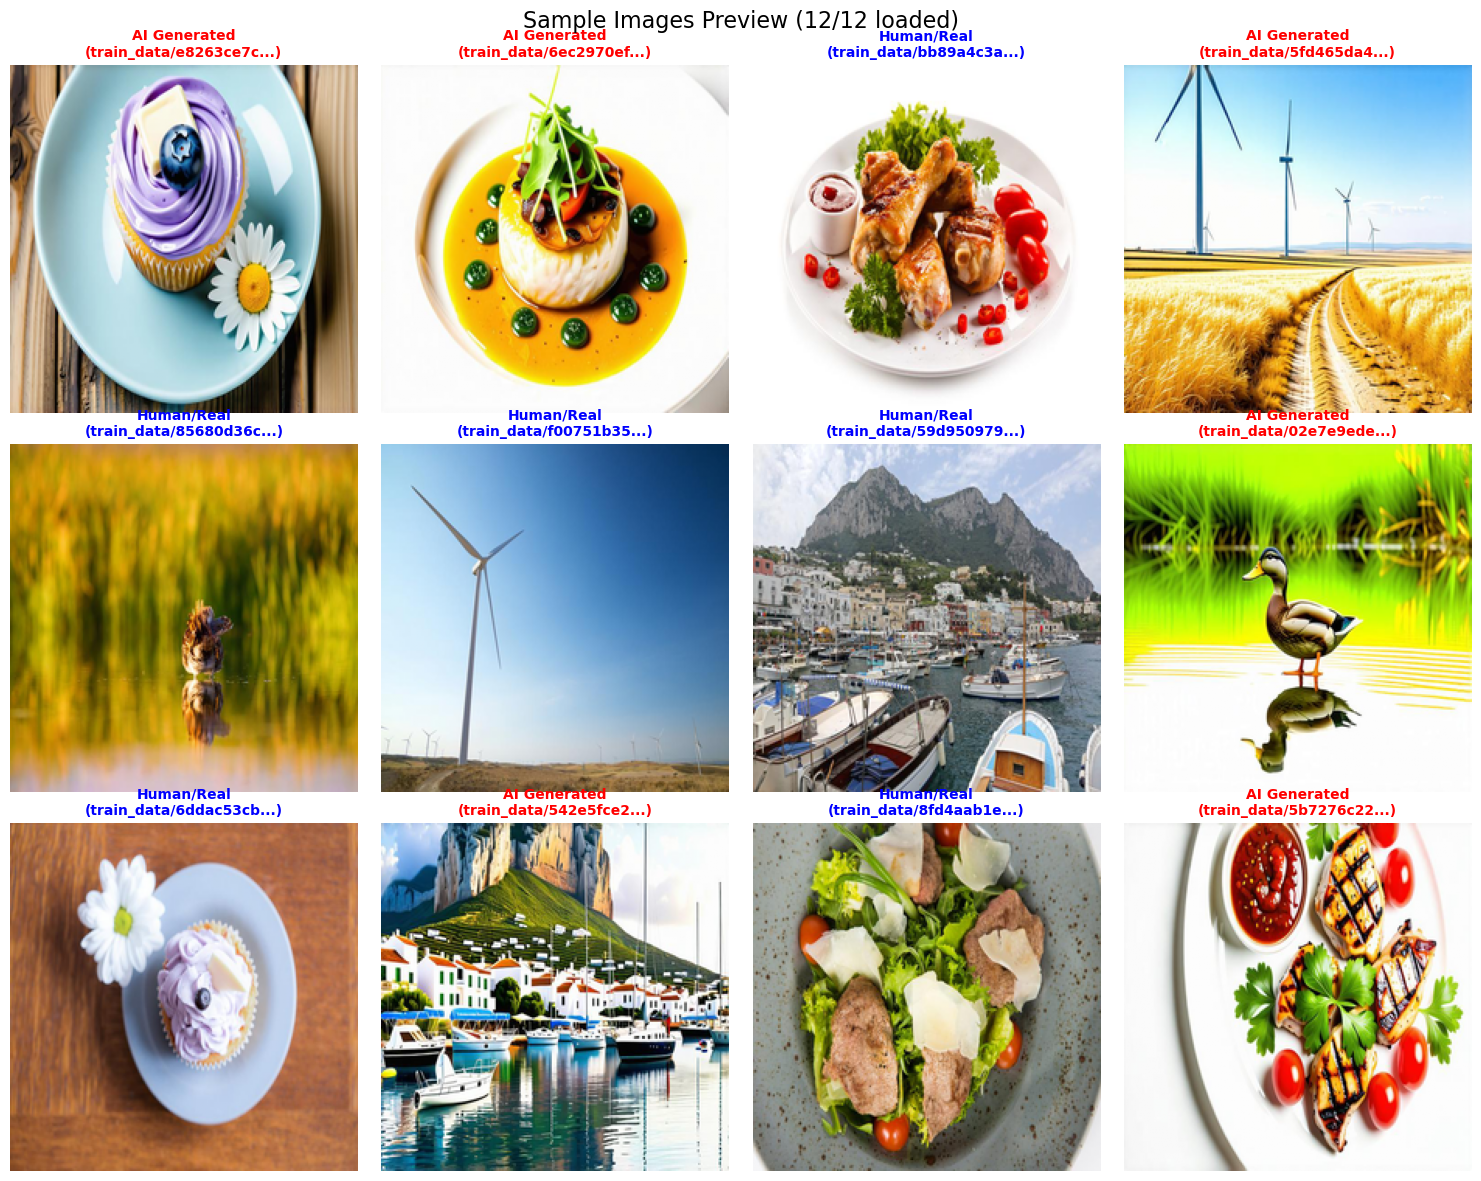


STEP 2: LOADING DATASET FOR TRAINING
Available columns: ['#', 'file_name', 'label']
Sample data:
   #                                        file_name  label
0  0  train_data/a6dcb93f596a43249135678dfcfc17ea.jpg      1
1  1  train_data/041be3153810433ab146bc97d5af505c.jpg      0
Filename column: 'file_name'
Label column: 'label'

Loading dataset (max 2000 samples)...
Processing 2000 images...
  Progress: 100/2000 (5.0%)
  Progress: 200/2000 (10.0%)
  Progress: 300/2000 (15.0%)
  Progress: 400/2000 (20.0%)
  Progress: 500/2000 (25.0%)
  Progress: 600/2000 (30.0%)
  Progress: 700/2000 (35.0%)
  Progress: 800/2000 (40.0%)
  Progress: 900/2000 (45.0%)
  Progress: 1000/2000 (50.0%)
  Progress: 1100/2000 (55.0%)
  Progress: 1200/2000 (60.0%)
  Progress: 1300/2000 (65.0%)
  Progress: 1400/2000 (70.0%)
  Progress: 1500/2000 (75.0%)
  Progress: 1600/2000 (80.0%)
  Progress: 1700/2000 (85.0%)
  Progress: 1800/2000 (90.0%)
  Progress: 1900/2000 (95.0%)
  Progress: 2000/2000 (100.0%)

Dataset loa

In [ ]:
if data:
    train_df, test_df = data
    results = run_full_analysis(train_df)

In [ ]:
# import necessary libraries for deep learning and other ML model testing
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# set style for better plots
plt.style.use('default')
sns.set_palette("husl")

print("Faux Real - An AI Image Detection Tool: Model Comparison with Test Prediction")
print("="*70)

class Config:
    # local file paths
    TRAIN_CSV = r"C:\Users\adras\OneDrive\Desktop\Capstone\train.csv"
    TEST_CSV = r"C:\Users\adras\OneDrive\Desktop\Capstone\test.csv"
    TRAIN_IMAGE_DIR = r"C:\Users\adras\train_data"
    TEST_IMAGE_DIR = r"C:\Users\adras\test_data"
    
    # model parameters
    IMG_SIZE = (224, 224)
    BATCH_SIZE = 16
    EPOCHS = 10
    MAX_SAMPLES = 2000  # reduced for better performance on local hardware
    
    # display settings
    FIGURE_SIZE = (12, 8)
    DPI = 100

config = Config()

def check_files_exist():
    """Check if all required files exist"""
    files_to_check = [
        (config.TRAIN_CSV, "Train CSV"),
        (config.TEST_CSV, "Test CSV"),
        (config.TRAIN_IMAGE_DIR, "Train Images Directory"),
        (config.TEST_IMAGE_DIR, "Test Images Directory")
    ]
    
    all_exist = True
    for file_path, description in files_to_check:
        if os.path.exists(file_path):
            print(f"{description}: Found")
        else:
            print(f"{description}: NOT FOUND - {file_path}")
            all_exist = False
    
    return all_exist

def load_data():
    """Load CSV files and return dataframes"""
    try:
        train_df = pd.read_csv(config.TRAIN_CSV)
        test_df = pd.read_csv(config.TEST_CSV)
        
        print(f"Train dataset: {len(train_df)} rows, {len(train_df.columns)} columns")
        print(f"Test dataset: {len(test_df)} rows, {len(test_df.columns)} columns")
        
        print("\nTrain columns:", list(train_df.columns))
        print("Test columns:", list(test_df.columns))
        
        return train_df, test_df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None

def find_columns(df):
    """Auto-detect filename and label columns with better logic"""
    filename_col = None
    label_col = None
    
    print(f"Available columns: {list(df.columns)}")
    print(f"Sample data:\n{df.head(2)}")
    
    # find filename column
    filename_candidates = ['filename', 'image', 'file', 'image_name', 'img', 'name', 'path']
    for col in df.columns:
        col_lower = col.lower()
        if any(candidate in col_lower for candidate in filename_candidates):
            filename_col = col
            break
    
    if not filename_col:
        filename_col = df.columns[0]
        print(f"Using first column as filename: {filename_col}")
    
    # find label column (only for training data)
    label_candidates = ['label', 'target', 'class', 'y', 'is_ai', 'ai', 'real']
    for col in df.columns:
        col_lower = col.lower()
        if any(candidate in col_lower for candidate in label_candidates):
            unique_vals = set(df[col].dropna().unique())
            # Check if it's binary (0/1 or similar)
            if unique_vals.issubset({0, 1, 0.0, 1.0, '0', '1', True, False}):
                label_col = col
                break
    
    # fallback: find any column with binary values to classify training data as 'AI' or 'Human'
    if not label_col:
        for col in df.columns:
            if col != filename_col:
                try:
                    unique_vals = set(df[col].dropna().astype(str).unique())
                    if unique_vals.issubset({'0', '1', 'True', 'False', '0.0', '1.0'}):
                        label_col = col
                        break
                except:
                    continue
    
    print(f"Filename column: '{filename_col}'")
    print(f"Label column: '{label_col}'")
    
    return filename_col, label_col

def load_and_preprocess_image(filename, image_dir, target_size=None):
    """Load and preprocess a single image with better error handling"""
    if target_size is None:
        target_size = config.IMG_SIZE
    
    clean_filename = str(filename).replace('\\', '/').replace('train_data/', '').replace('test_data/', '')
    
    # try different path constructions
    possible_paths = [
        os.path.join(image_dir, clean_filename),
        os.path.join(image_dir, os.path.basename(clean_filename)),
        os.path.join(image_dir, filename) if isinstance(filename, str) else None
    ]
    
    for img_path in possible_paths:
        if img_path and os.path.exists(img_path):
            try:
                img = Image.open(img_path).convert('RGB')
                img = img.resize(target_size, Image.Resampling.LANCZOS)
                img_array = np.array(img) / 255.0  # Normalize to [0,1]
                return img_array
            except Exception as e:
                continue
    
    return None

def load_dataset(df, image_dir, max_samples=None, has_labels=True):
    """Load and prepare dataset for training/testing with progress tracking"""
    if max_samples is None:
        max_samples = config.MAX_SAMPLES
    
    filename_col, label_col = find_columns(df)
    
    if has_labels and label_col is None:
        print("No valid label column found!")
        return None, None, None
    
    print(f"\nLoading dataset (max {max_samples} samples)...")
    
    # maintaining class balance for training data
    if has_labels and len(df) > max_samples:
        class_counts = df[label_col].value_counts()
        samples_per_class = max_samples // len(class_counts)
        
        df_sample = df.groupby(label_col).apply(
            lambda x: x.sample(min(len(x), samples_per_class), random_state=42)
        ).reset_index(drop=True).sample(frac=1, random_state=42)
    elif not has_labels and len(df) > max_samples:
        df_sample = df.sample(max_samples, random_state=42)
    else:
        df_sample = df.copy()
    
    images = []
    labels = []
    filenames = []
    failed_files = []
    
    print(f"Processing {len(df_sample)} images...")
    
    for i, (_, row) in enumerate(df_sample.iterrows()):
        filename = str(row[filename_col])
        img = load_and_preprocess_image(filename, image_dir)
        
        if img is not None:
            images.append(img)
            filenames.append(filename)
            
            if has_labels:
                # ensure labels are binary (0/1)
                label_val = row[label_col]
                if str(label_val).lower() in ['1', '1.0', 'true', 'ai']:
                    labels.append(1)
                else:
                    labels.append(0)
        else:
            failed_files.append(filename)
        
        # progress indicator
        if (i + 1) % 100 == 0 or i == len(df_sample) - 1:
            print(f"  Progress: {i + 1}/{len(df_sample)} ({(i+1)/len(df_sample)*100:.1f}%)")
    
    if not images:
        print("No images could be loaded!")
        return None, None, None
    
    X = np.array(images)
    y = np.array(labels) if has_labels else None
    
    print(f"\nDataset loaded successfully!")
    print(f"  Images shape: {X.shape}")
    if has_labels:
        print(f"  Labels distribution: {Counter(y)}")
    print(f"  Failed to load: {len(failed_files)} images")
    
    return X, y, filenames

def create_optimized_models():
    """Create optimized models with callbacks"""
    models = {}
    
    # early stopping and learning rate reduction
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7)
    callbacks = [early_stopping, reduce_lr]
    
    # 1. ResNet50 transfer learning
    print("Creating ResNet50 model...")
    base_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(*config.IMG_SIZE, 3))
    base_resnet.trainable = False
    
    resnet_model = Sequential([
        base_resnet,
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    
    resnet_model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    models['ResNet50'] = {'model': resnet_model, 'callbacks': callbacks}
    
    # 2. Custom CNN
    print("Creating Custom CNN model...")
    custom_cnn = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(*config.IMG_SIZE, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    custom_cnn.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    models['Custom CNN'] = {'model': custom_cnn, 'callbacks': callbacks}
    
    return models

def train_models(X_train, y_train):
    """Train all models with proper validation and progress tracking"""
    # split training data for validation
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )
    
    print(f"\nData split:")
    print(f"  Training: {len(X_tr)} images")
    print(f"  Validation: {len(X_val)} images")
    print(f"  Training distribution: {Counter(y_tr)}")
    print(f"  Validation distribution: {Counter(y_val)}")
    
    # create models
    models = create_optimized_models()
    results = {}
    
    for name, model_info in models.items():
        print(f"\nTraining {name}...")
        print("-" * 50)
        
        model = model_info['model']
        callbacks = model_info['callbacks']
        
        # train model
        history = model.fit(
            X_tr, y_tr,
            validation_data=(X_val, y_val),
            epochs=config.EPOCHS,
            batch_size=config.BATCH_SIZE,
            callbacks=callbacks,
            verbose=1
        )
        
        # evaluate
        train_loss, train_acc = model.evaluate(X_tr, y_tr, verbose=0)
        val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
        
        # predictions on validation set
        y_pred_proba = model.predict(X_val, verbose=0)
        y_pred = (y_pred_proba > 0.5).astype(int).flatten()
        
        results[name] = {
            'model': model,
            'history': history,
            'train_accuracy': train_acc,
            'val_accuracy': val_acc,
            'predictions': y_pred,
            'y_true': y_val
        }
        
        print(f"{name} Results:")
        print(f"   Training Accuracy: {train_acc:.4f}")
        print(f"   Validation Accuracy: {val_acc:.4f}")
        print(f"   Overfitting: {train_acc - val_acc:.4f}")
    
    return results

def predict_test_data(models_results, X_test, test_filenames):
    """Make predictions on test data using trained models"""
    print(f"\nMaking predictions on {len(X_test)} test images...")
    
    test_predictions = {}
    
    for name, result in models_results.items():
        model = result['model']
        
        print(f"Predicting with {name}...")
        
        # get prediction probabilities
        pred_probabilities = model.predict(X_test, verbose=0)
        pred_classes = (pred_probabilities > 0.5).astype(int).flatten()
        
        # convert to readable labels
        pred_labels = ['AI Generated' if pred == 1 else 'Human/Real' for pred in pred_classes]
        
        test_predictions[name] = {
            'probabilities': pred_probabilities.flatten(),
            'classes': pred_classes,
            'labels': pred_labels
        }
        
        # show prediction distribution
        pred_counts = Counter(pred_labels)
        print(f"  {name} predictions: {dict(pred_counts)}")
    
    return test_predictions

def create_test_predictions_dataframe(test_filenames, test_predictions, models_results):
    """Create a comprehensive dataframe with test predictions"""
    
    # start with filenames
    results_df = pd.DataFrame({'filename': test_filenames})
    
    # add predictions from each model
    for name, predictions in test_predictions.items():
        results_df[f'{name}_probability'] = predictions['probabilities']
        results_df[f'{name}_prediction'] = predictions['labels']
        results_df[f'{name}_confidence'] = np.where(
            predictions['probabilities'] > 0.5,
            predictions['probabilities'],
            1 - predictions['probabilities']
        )
    
    # create ensemble prediction
    model_predictions = np.array([pred['classes'] for pred in test_predictions.values()])
    ensemble_pred = (np.mean(model_predictions, axis=0) > 0.5).astype(int)
    ensemble_labels = ['AI Generated' if pred == 1 else 'Human/Real' for pred in ensemble_pred]
    
    results_df['ensemble_prediction'] = ensemble_labels
    results_df['ensemble_confidence'] = np.mean([pred['probabilities'] for pred in test_predictions.values()], axis=0)
    
    return results_df

def visualize_test_predictions(X_test, test_filenames, test_predictions, num_samples=16):
    """Visualize test images with model predictions"""
    
    # get a random sample of test images
    indices = np.random.choice(len(X_test), min(num_samples, len(X_test)), replace=False)
    
    cols = 4
    rows = (num_samples + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(16, 4*rows))
    
    if rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()
    
    model_names = list(test_predictions.keys())
    
    for i, idx in enumerate(indices):
        if i >= num_samples:
            break
        
        # display image
        axes[i].imshow(X_test[idx])
        
        # create title with all model predictions
        filename = os.path.basename(test_filenames[idx])[:15]
        title = f"{filename}...\n"
        
        for name in model_names:
            pred_label = test_predictions[name]['labels'][idx]
            confidence = test_predictions[name]['probabilities'][idx]
            
            if pred_label == 'AI Generated':
                conf_val = confidence
            else:
                conf_val = 1 - confidence
            
            title += f"{name}: {pred_label} ({conf_val:.2f})\n"
        
        axes[i].set_title(title, fontsize=9, weight='bold')
        axes[i].axis('off')
    
    # hide unused subplots
    for i in range(len(indices), len(axes)):
        axes[i].axis('off')
    
    plt.suptitle('Test Data Predictions', fontsize=16, weight='bold')
    plt.tight_layout()
    plt.show()

def plot_prediction_confidence_distribution(test_predictions):
    """Plot confidence distribution for predictions"""
    fig, axes = plt.subplots(1, len(test_predictions), figsize=(5*len(test_predictions), 5))
    
    if len(test_predictions) == 1:
        axes = [axes]
    
    for i, (name, predictions) in enumerate(test_predictions.items()):
        confidences = np.where(
            predictions['probabilities'] > 0.5,
            predictions['probabilities'],
            1 - predictions['probabilities']
        )
        
        axes[i].hist(confidences, bins=20, alpha=0.7, edgecolor='black')
        axes[i].set_title(f'{name}\nConfidence Distribution')
        axes[i].set_xlabel('Confidence Score')
        axes[i].set_ylabel('Frequency')
        axes[i].grid(True, alpha=0.3)
        
        # add statistics
        mean_conf = np.mean(confidences)
        axes[i].axvline(mean_conf, color='red', linestyle='--', 
                       label=f'Mean: {mean_conf:.3f}')
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()

def save_test_predictions(results_df, filename='test_predictions.csv'):
    """Save test predictions to CSV file"""
    try:
        results_df.to_csv(filename, index=False)
        print(f"Test predictions saved to: {filename}")
        return True
    except Exception as e:
        print(f"Error saving predictions: {e}")
        return False

# main execution functions
def initialize_and_check():
    """Initialize and check all files"""
    print("Checking file paths...")
    if not check_files_exist():
        print("\nSome files are missing. Please check your file paths!")
        return False
    
    print("\nLoading CSV files...")
    train_df, test_df = load_data()
    if train_df is None:
        return False
    
    return train_df, test_df

def run_complete_analysis_with_test_prediction(train_df, test_df):
    """Run complete analysis including test prediction"""
    print("\nStarting Complete AI Image Detection Analysis with Test Prediction")
    print("="*80)
    
    # Step 1: Load training dataset
    print("\nSTEP 1: LOADING TRAINING DATASET")
    X_train, y_train, train_filenames = load_dataset(train_df, config.TRAIN_IMAGE_DIR, config.MAX_SAMPLES, has_labels=True)
    
    if X_train is None:
        print("Failed to load training dataset!")
        return None
    
    # Step 2: Train models
    print("\nSTEP 2: TRAINING MODELS")
    models_results = train_models(X_train, y_train)
    
    # Step 3: Load test dataset
    print("\nSTEP 3: LOADING TEST DATASET")
    X_test, _, test_filenames = load_dataset(test_df, config.TEST_IMAGE_DIR, config.MAX_SAMPLES, has_labels=False)
    
    if X_test is None:
        print("Failed to load test dataset!")
        return models_results
    
    # Step 4: Make predictions on test data
    print("\nSTEP 4: MAKING PREDICTIONS ON TEST DATA")
    test_predictions = predict_test_data(models_results, X_test, test_filenames)
    
    # Step 5: Create results dataframe
    print("\nSTEP 5: CREATING RESULTS SUMMARY")
    results_df = create_test_predictions_dataframe(test_filenames, test_predictions, models_results)
    
    # Step 6: Visualizations
    print("\nSTEP 6: CREATING VISUALIZATIONS")
    visualize_test_predictions(X_test, test_filenames, test_predictions, num_samples=12)
    plot_prediction_confidence_distribution(test_predictions)
    
    # Step 7: Save results
    print("\nSTEP 7: SAVING RESULTS")
    save_test_predictions(results_df)
    
    print(f"\nTest Predictions Summary:")
    print(f"Total test images processed: {len(results_df)}")
    print(f"Results saved with {len(models_results)} model predictions plus ensemble")
    
    print("\nANALYSIS COMPLETE!")
    return models_results, test_predictions, results_df

# one-stop function for ease of use
def run_full_pipeline():
    """Run the complete pipeline from start to finish"""
    data = initialize_and_check()
    if data:
        train_df, test_df = data
        return run_complete_analysis_with_test_prediction(train_df, test_df)
    else:
        print("Failed to initialize. Please check your file paths.")
        return None

In [ ]:
run_full_pipeline()